# Bank Churn Neural Network Model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

from imblearn.over_sampling import SMOTE

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data Preprocessing

In [4]:
df = pd.read_csv('../content/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.duplicated().sum()

0

In [5]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
df[(df['Exited'] != 0)&(df['Exited']!=1)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [7]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


Thus, this is an unbalanced dataset. Next, I will drop unrelated features

### Split Data and apply Dummy Coding

In [8]:
X = df.drop(columns = ['Surname', 'Exited', 'CustomerId', 'RowNumber'])
y = df['Exited']

X_encoded = pd.get_dummies(X, drop_first=True, dtype=float)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42, stratify = y)

### Scaling (excluding binary columns)

In [9]:
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Convert scaled NumPy array back to DataFrame
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),
                              columns=numerical_features, index=X_train.index)

X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_features]),
                             columns=numerical_features, index=X_test.index)

In [10]:
# Concat dataframe back
X_train_final = pd.concat([X_train_scaled, X_train.drop(columns=numerical_features)], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test.drop(columns=numerical_features)], axis=1)

### Resampling using SMOTE (Synthetic Minority Over-sampling Technique)

In [11]:
print(y_train.value_counts())
print(y_train.value_counts(normalize = True))

Exited
0    5574
1    1426
Name: count, dtype: int64
Exited
0    0.796286
1    0.203714
Name: proportion, dtype: float64


In [12]:
print(f'Proportion of positive class / negative class: {y_train.value_counts()[1]/y_train.value_counts()[0]:.4f}')

Proportion of positive class / negative class: 0.2558


In [13]:
desired_ratio = 0.7  # the minority class becomes 70% of the majority class size

smote = SMOTE(sampling_strategy=desired_ratio, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_train)

In [14]:
print(y_resampled.value_counts())
print(y_resampled.value_counts(normalize = True))

Exited
0    5574
1    3901
Name: count, dtype: int64
Exited
0    0.588285
1    0.411715
Name: proportion, dtype: float64


In [15]:
print(f'Proportion of positive class / negative class: {y_resampled.value_counts()[1]/y_resampled.value_counts()[0]:.4f}')

Proportion of positive class / negative class: 0.6999


## Data Prediction

In [16]:
features = torch.tensor(X_resampled.to_numpy()).float()
target = torch.tensor(y_resampled.to_numpy()).float()

dataset = TensorDataset(features, target)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)

In [41]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 4)
        self.bn3 = nn.BatchNorm1d(4)
        self.fc4 = nn.Linear(4, 1)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight)
        init.kaiming_uniform_(self.fc4.weight, nonlinearity="sigmoid")

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = nn.functional.elu(x)

        x = nn.functional.sigmoid(self.fc4(x))
        return x
input_dim = X_train.shape[1]
model = Net(input_dim)

In [42]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [43]:
# Early stopping parameters
patience = 10 # Number of epochs to wait before stopping
min_val_loss = float('inf') # Initialize with a very high value
count = 0 # Tracks how many epochs the val_loss hasn't improved
best_model_state = None

# epoch
num_epochs = 200
train_loss = []
val_loss = []

In [44]:
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0

    for data in train_loader:
        # Set the gradients to zero
        optimizer.zero_grad()
        feature, target = data
        pred = model(feature)

        loss = criterion(pred.squeeze(), target.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    epoch_train_loss = training_loss / len(train_loader)
    train_loss.append(epoch_train_loss)

    # Validation Phase
    model.eval()
    validation_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            feature, target = data
            pred = model(feature)

            loss = criterion(pred.squeeze(), target.float())
            validation_loss += loss.item()

    epoch_val_loss = validation_loss / len(val_loader)
    val_loss.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping check
    if epoch_val_loss < min_val_loss:
      min_val_loss = epoch_val_loss
      count = 0

      # Store the best model so the model will not keep the last-trained weights instead of the best-performing ones
      best_model_state = model.state_dict()
    else:
      count += 1
      if count >= patience:
        epoch = epoch + 1 # assign variable for plotting
        print(print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {min_val_loss:.4f} at Epoch: {epoch}/{num_epochs}"))
        break

model.train()

Epoch 1/200 - Train Loss: 0.7401, Val Loss: 0.6990
Epoch 2/200 - Train Loss: 0.6686, Val Loss: 0.6476
Epoch 3/200 - Train Loss: 0.6291, Val Loss: 0.6166
Epoch 4/200 - Train Loss: 0.6013, Val Loss: 0.6060
Epoch 5/200 - Train Loss: 0.5802, Val Loss: 0.5777
Epoch 6/200 - Train Loss: 0.5672, Val Loss: 0.5725
Epoch 7/200 - Train Loss: 0.5635, Val Loss: 0.5694
Epoch 8/200 - Train Loss: 0.5541, Val Loss: 0.5629
Epoch 9/200 - Train Loss: 0.5503, Val Loss: 0.5595
Epoch 10/200 - Train Loss: 0.5467, Val Loss: 0.5548
Epoch 11/200 - Train Loss: 0.5421, Val Loss: 0.5508
Epoch 12/200 - Train Loss: 0.5377, Val Loss: 0.5486
Epoch 13/200 - Train Loss: 0.5309, Val Loss: 0.5440
Epoch 14/200 - Train Loss: 0.5291, Val Loss: 0.5472
Epoch 15/200 - Train Loss: 0.5304, Val Loss: 0.5375
Epoch 16/200 - Train Loss: 0.5282, Val Loss: 0.5308
Epoch 17/200 - Train Loss: 0.5178, Val Loss: 0.5271
Epoch 18/200 - Train Loss: 0.5209, Val Loss: 0.5202
Epoch 19/200 - Train Loss: 0.5119, Val Loss: 0.5181
Epoch 20/200 - Train 

Net(
  (fc1): Linear(in_features=11, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (bn3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)

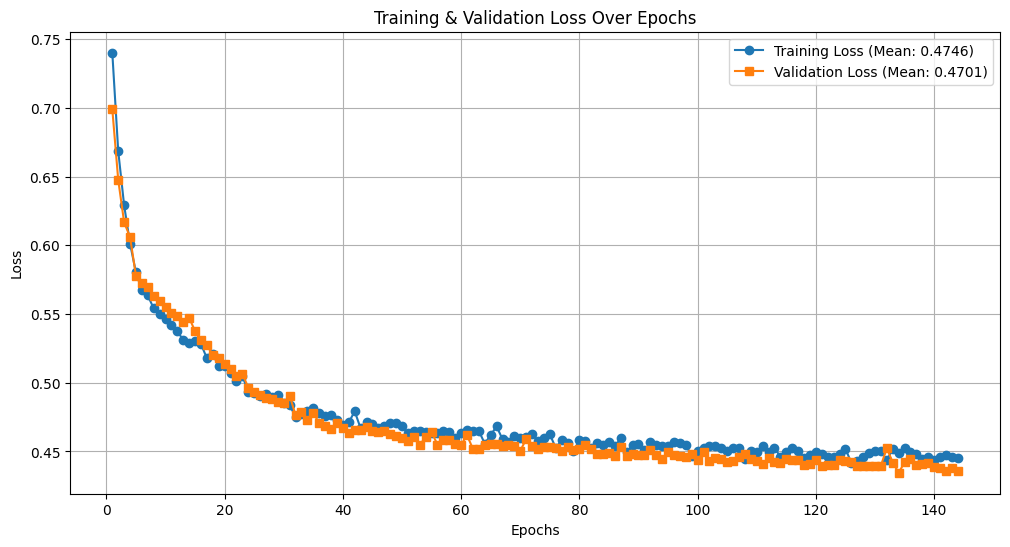

In [45]:
mean_train_loss = sum(train_loss) / len(train_loss)
mean_val_loss = sum(val_loss) / len(val_loss)

# Plot the Loss Curve
if num_epochs > epoch + 1:
    range_epoch = epoch
else: range_epoch = num_epochs

plt.figure(figsize = (12, 6))
plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

##### Training loss is close and a bit higher than validation loss; the model generalizes well and does not overfit.

In [46]:
if best_model_state:
    model.load_state_dict(best_model_state)

In [47]:
features_test = torch.tensor(X_test_final.to_numpy()).float()
target_test = torch.tensor(y_test.to_numpy()).float()

test_dataset = TensorDataset(features_test, target_test)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [48]:
model.eval()

testing_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []
all_probs = []

threshold = 0.5

with torch.no_grad():
    for data in test_loader:
        feature, target = data
        pred = model(feature)

        loss = criterion(pred.squeeze(), target.float())
        testing_loss += loss.item()

        # Compute for Confusion Matrix and Classification report
        pred_label = (pred.squeeze() >= threshold).float()
        correct += (pred_label == target).sum().item()
        total += target.size(0)

        # Store results for Confusion Matrix
        all_preds.extend(pred_label.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

        # Store probabilities for Precision-Recall Curve
        all_probs.extend(pred.cpu().numpy())

average_test_loss = testing_loss / len(test_loader)
print(f'Testing Loss: {average_test_loss:.4f}')

Testing Loss: 0.3799


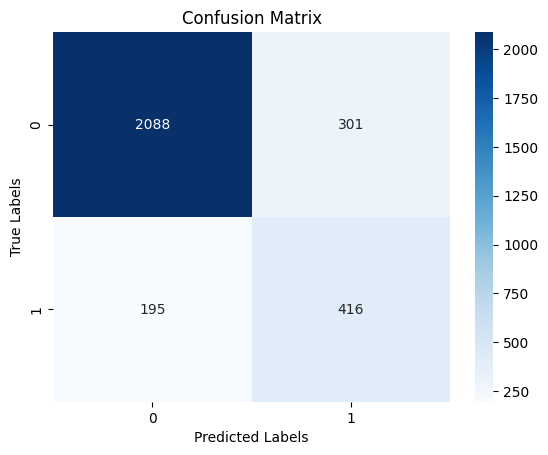

In [49]:
conf_matrix = confusion_matrix(all_targets, all_preds)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

##### Lower FN than Higher FP → The number of customers churning being predicted as not churning is the lowest among the four. Trade-off where more non-churning customers are being misclassified as churning.

In [50]:
class_report = classification_report(all_targets, all_preds)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      2389
         1.0       0.58      0.68      0.63       611

    accuracy                           0.83      3000
   macro avg       0.75      0.78      0.76      3000
weighted avg       0.85      0.83      0.84      3000



In [51]:
precision, recall, thresholds = precision_recall_curve(all_targets, all_probs)
pr_auc = auc(recall, precision)
print(f'Area Under the Precision-Recall Curve (PR AUC): {pr_auc:.4f}')

Area Under the Precision-Recall Curve (PR AUC): 0.7138


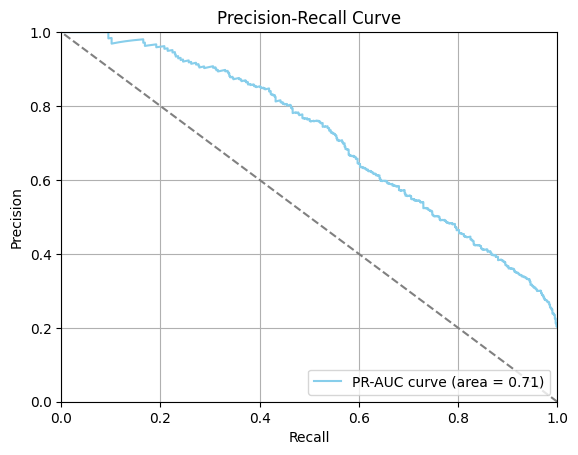

In [52]:
plt.plot(recall, precision, color = 'skyblue', label='PR-AUC curve (area = {:.2f})'.format(pr_auc))
plt.plot([1, 0], [0, 1], color='gray', linestyle='--') # random classifier line
plt.xlim([0.0, 1.0]) # set the limits of the x-axis
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

##### The PR curve drops sharply: the model loses precision as recall increases

### Extract feature weights from model

In [53]:
state_dict = model.state_dict()
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'fc2.weight', 'fc2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'fc3.weight', 'fc3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'fc4.weight', 'fc4.bias'])


In [54]:
first_layer_weights = state_dict['fc1.weight']
feature_importance = first_layer_weights.detach().numpy().flatten() # deteach = perform operation on tensor but not track gradient descent
feature_names = X_test_final.columns
importance_dict = dict(zip(feature_names, feature_importance))

sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

Age: 1.5358662605285645
Geography_Germany: 0.5043913125991821
Balance: 0.3655877709388733
HasCrCard: 0.3568597733974457
NumOfProducts: 0.13351435959339142
Gender_Male: 0.07871586829423904
Tenure: 0.07312635332345963
Geography_Spain: -0.03921941667795181
CreditScore: -0.22120071947574615
IsActiveMember: -0.3343174159526825
EstimatedSalary: -0.46430858969688416


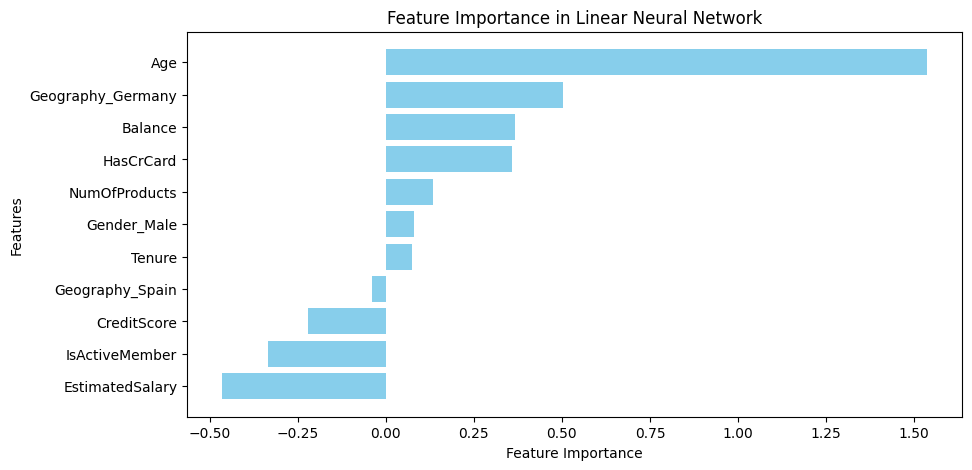

In [55]:
sorted_features = [f[0] for f in sorted_importance]
sorted_values = [f[1] for f in sorted_importance]

plt.figure(figsize=(10,5))
plt.barh(sorted_features, sorted_values, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Linear Neural Network")
plt.gca().invert_yaxis()
plt.show()